In [1]:
import os, sys, glob
from datetime import datetime
sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')

from mi.instrument.kut.ek60.ooicore.zplsc_b import *
from concat_raw import *

data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
fname1 = glob.glob(os.path.join(data_path,'OOI-D20150910-T*.raw'))
fname2 = glob.glob(os.path.join(data_path,'OOI-D20170910-T*.raw'))
fname1 = fname1[0]
fname2 = fname2[0]

In [2]:
%matplotlib inline

Load data:

In [3]:
particle_data1, data_times1, power_data_dict1, freq1, bin_size1, config_header1, config_transducer1 = parse_echogram_file(fname1)

2017-09-17 22:57:01,681 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150910-T000000.raw'


In [4]:
particle_data2, data_times2, power_data_dict2, freq2, bin_size2, config_header2, config_transducer2 = parse_echogram_file(fname2)

2017-09-17 22:57:04,241 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20170910-T000000.raw'


### Function for noise estimation

In [5]:
def get_noise(power_data,depth_bin_size,ping_bin_range,depth_bin_range,tvgCorrectionFactor=2):
    '''
    INPUT:
        ping_bin_range        average over M pings
        depth_bin_range       average over depth_bin_range [m]
        tvgCorrectionFactor   default (=2) is to apply TVG correction with offset of 2 samples
                              note this factor is important in TVG compensation
                              and therefore in how power_bin is obtained as well
    OUTPUT:
        minimum value for bins of averaged ping
    '''
    N = int(np.floor(depth_bin_range/depth_bin_size))
    
    # Average uncompensated power over M pings and N depth bins
    depth_bin_num = int(np.floor((power_data.shape[0]-tvgCorrectionFactor)/N))
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    power_bin = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N)+N*iD+tvgCorrectionFactor  # match the 2-sample offset
            ping_idx = np.arange(ping_bin_range)+ping_bin_range*iP
            power_bin[iD,iP] = np.mean(10**(power_data[np.ix_(depth_idx,ping_idx)]/10))

    # Noise = minimum value for each averaged ping
    return np.min(power_bin,0)

### Function for noise removal and TVG + absorption compensation

In [6]:
def remove_noise(power_data,cal,noise_est,ping_bin_range=40,tvg_correction_factor=2):
    '''
    Function for noise removal and TVG + absorption compensation
    fn      sequence number of that particular freq in power_data
            corresponds to index fn-1 in cal_params
    tvg_correction_factor   default(=2) for converting power_data to Sv
    '''

    # Get cal params
    f = cal['frequency']
    c = cal['soundvelocity']
    t = cal['sampleinterval']
    alpha = cal['absorptioncoefficient']
    G = cal['gain']
    phi = cal['equivalentbeamangle']
    pt = cal['transmitpower']
    tau = cal['pulselength']

    # key derived params
    dR = c*t/2   # sample thickness
    wvlen = c/f  # wavelength

    # Calc gains
    CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

    # calculate Sa Correction
    idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
    Sac = 2 * cal['sacorrectiontable'][idx]

    # Get TVG
    range_vec = np.arange(power_data.shape[0]) * dR
    rangeCorrected = range_vec - (tvg_correction_factor * dR)
    rangeCorrected[rangeCorrected<0] = 0

    TVG = np.empty(rangeCorrected.shape)
    TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
    TVG[rangeCorrected==0] = 0

    # Get absorption
    ABS = 2*alpha*rangeCorrected

    # Compensate measurement for noise and corrected for transmission loss
    # also estimate Sv_noise component for subsequent SNR check

    # Method 1: subtract before compensate
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    Sv_corr1 = np.empty(power_data.shape)   # log domain corrected Sv
    Sv_noise = np.empty(power_data.shape)  # Sv_noise
    for iP in range(ping_bin_num):
        ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
        subtract1 = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
        tmp1 = np.empty(subtract1.shape)
        tmp1[subtract1>0] = 10*np.log10(subtract1[subtract1>0])
        tmp1[subtract1<=0] = -999
        tmp1 = (tmp1.T +TVG+ABS).T
        Sv_corr1[:,ping_idx] = tmp1
        Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG +ABS]*ping_bin_range).T

    # Method 2: compensate before subtract
    Sv_raw = (power_data.T+TVG+ABS).T  # compensation first (log domain)
    subtract2 = 10**(Sv_raw/10)-10**(Sv_noise/10)
    tmp2 = np.empty(subtract2.shape)
    tmp2[subtract2>0] = 10*np.log10(subtract2[subtract2>0])
    tmp2[subtract2<=0] = -999
    Sv_corr2 = tmp2
    
    # Output
    return Sv_raw,Sv_noise,Sv_corr1,Sv_corr2
    

## Clean up 20170910 data

In [9]:
power_data = power_data_dict2   # 20170910 data
cal_params = get_cal_params(power_data,particle_data1,config_header1,config_transducer1)
ping_bin_range = 40
depth_bin_range = 10
depth_bin_size = bin_size2
tvg_correction_factor = 2
fn = 1
noise_est_120 = get_noise(power_data[fn],depth_bin_size,ping_bin_range,depth_bin_range)
Sv_raw_120,Sv_noise_120,Sv_corr_120,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_120,ping_bin_range,tvg_correction_factor)
fn = 2
noise_est_38 = get_noise(power_data[fn],depth_bin_size,ping_bin_range,depth_bin_range)
Sv_raw_38,Sv_noise_38,Sv_corr_38,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_38,ping_bin_range,tvg_correction_factor)
fn = 3
noise_est_200 = get_noise(power_data[fn],depth_bin_size,ping_bin_range,depth_bin_range)
Sv_raw_200,Sv_noise_200,Sv_corr_200,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_200,ping_bin_range,tvg_correction_factor)

## Data with noise removed for all 3 frequencies

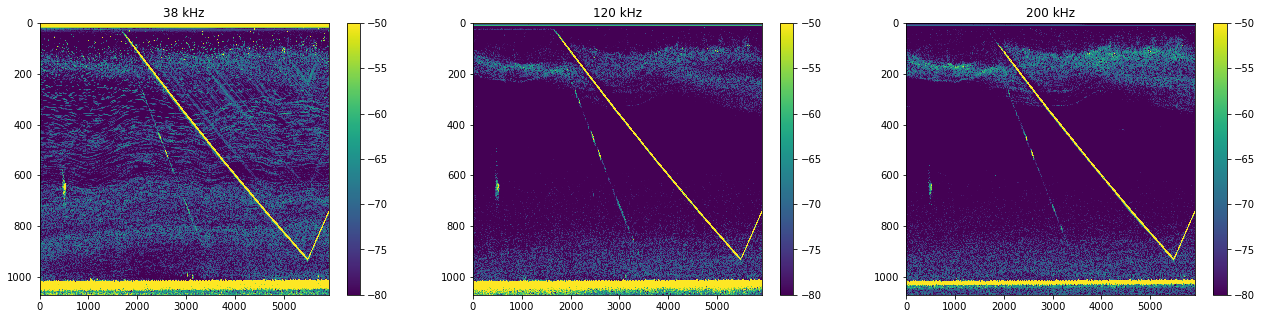

In [10]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_raw_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_raw_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

## Function to get mean MVBS after thresholding data based on Logerwill & Wilson 2004 method

In [11]:
def mean_MVBS_th(Sv,th,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS after thresholding Sv
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    Sv_cp = np.copy(Sv)
    Sv_cp[Sv_cp<=th] = np.nan  # set all values below th to np.nan
    
    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv_cp.shape[0]/N))
    ping_bin_num = int(np.floor(Sv_cp.shape[1]/ping_bin_range))
    MVBS = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N) + N*iD
            ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
            MVBS[iD,iP] = 10*np.log10( np.nanmean(10**(Sv_cp[np.ix_(depth_idx,ping_idx)]/10)) )

    # Set NaN pixels to -999
    #MVBS[np.isnan(MVBS)] = -999
            
    return MVBS

## Direct Sv thresholding

Here we use a threshold of -73 dB that was determined from the procedures in Logermill & Wilson in notebook `Sv_thresholding 20170910 data.ipynb`.

In [15]:
Sv_th = -73
Sv_corr_38_th = np.copy(Sv_corr_38)
Sv_corr_38_th[Sv_corr_38_th<=Sv_th] = np.nan  # set all values below th to np.nan
Sv_corr_120_th = np.copy(Sv_corr_120)
Sv_corr_120_th[Sv_corr_120_th<=Sv_th] = np.nan  # set all values below th to np.nan
Sv_corr_200_th = np.copy(Sv_corr_200)
Sv_corr_200_th[Sv_corr_200_th<=Sv_th] = np.nan  # set all values below th to np.nan

## Thresholding solely based on SNR

In [19]:
SNR_th = 10
SNR_38 = Sv_corr_38-Sv_noise_38
SNR_120 = Sv_corr_120-Sv_noise_120
SNR_200 = Sv_corr_200-Sv_noise_200
Sv_corr_38_SNR = np.copy(Sv_corr_38)
Sv_corr_38_SNR[SNR_38<SNR_th] = np.nan
Sv_corr_120_SNR = np.copy(Sv_corr_120)
Sv_corr_120_SNR[SNR_120<SNR_th] = np.nan
Sv_corr_200_SNR = np.copy(Sv_corr_200)
Sv_corr_200_SNR[SNR_200<SNR_th] = np.nan

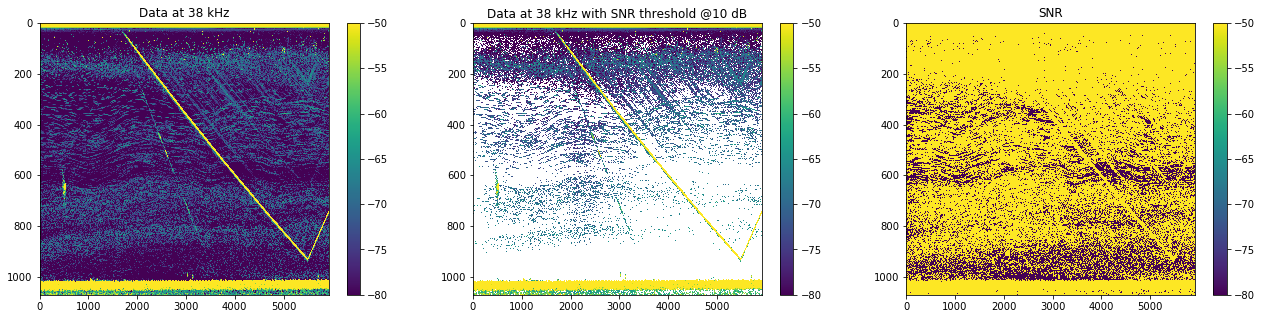

In [20]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Data at 38 kHz')
im1 = ax1.imshow(Sv_corr_38_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Data at 38 kHz with SNR threshold @%d dB' % SNR_th)
im2 = ax2.imshow(Sv_corr_38-Sv_noise_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('SNR')

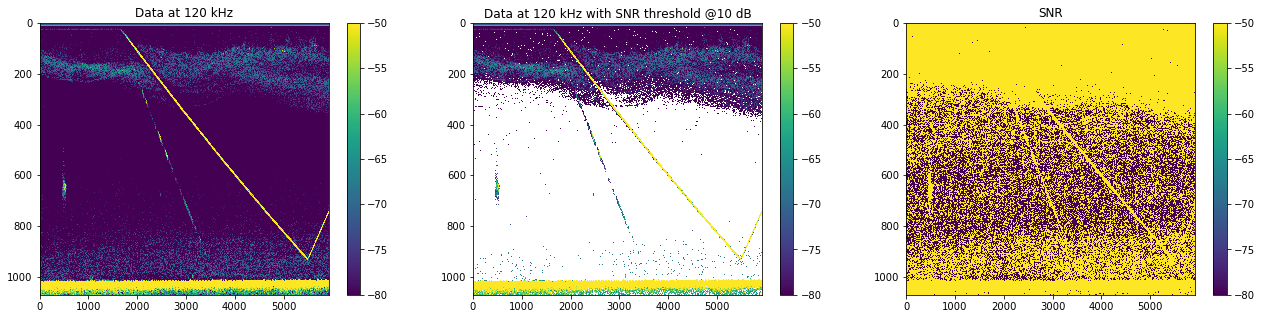

In [21]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Data at 120 kHz')
im1 = ax1.imshow(Sv_corr_120_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im2 = ax2.imshow(Sv_corr_120-Sv_noise_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('SNR')

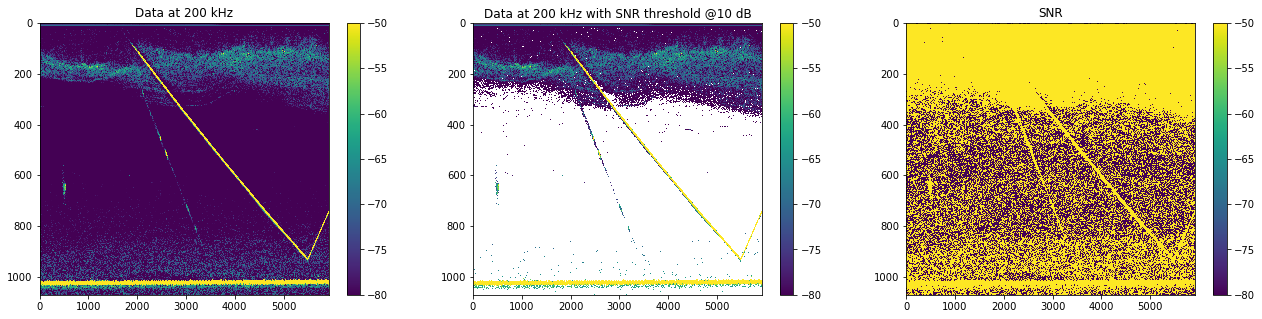

In [22]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Data at 200 kHz')
im1 = ax1.imshow(Sv_corr_200_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Data at 200 kHz with SNR threshold @%d dB' % SNR_th)
im2 = ax2.imshow(Sv_corr_200-Sv_noise_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('SNR')

## Function to obtain MVBS

In [25]:
def mean_MVBS(Sv,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv.shape[0]/N))
    ping_bin_num = int(np.floor(Sv.shape[1]/ping_bin_range))
    MVBS = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N) + N*iD
            ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
            MVBS[iD,iP] = 10*np.log10( np.nanmean(10**(Sv[np.ix_(depth_idx,ping_idx)]/10)) )
            
    return MVBS

In [27]:
Sv_corr_38_SNR_mean = mean_MVBS(Sv_corr_38_SNR,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_38_th_mean = mean_MVBS(Sv_corr_38_th,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_120_SNR_mean = mean_MVBS(Sv_corr_120_SNR,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_120_th_mean = mean_MVBS(Sv_corr_120_th,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_200_SNR_mean = mean_MVBS(Sv_corr_200_SNR,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_200_th_mean = mean_MVBS(Sv_corr_200_th,bin_size2,ping_bin_range=20,depth_bin_range=2)

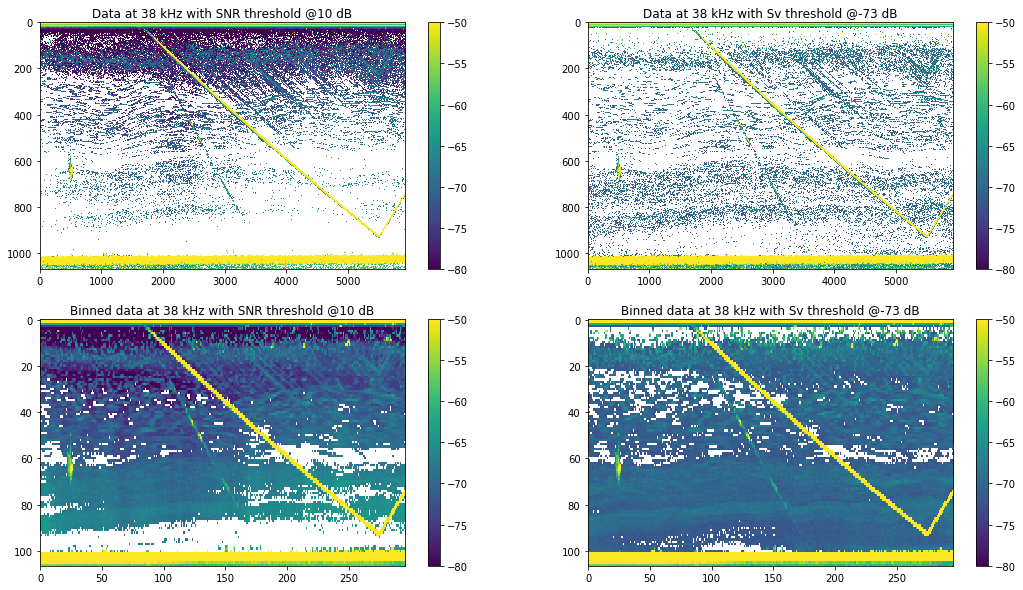

In [28]:
fig,ax = plt.subplots(2,2,figsize=(18,10))
im0 = ax[0,0].imshow(Sv_corr_38_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Data at 38 kHz with SNR threshold @%d dB' % SNR_th)
im1 = ax[0,1].imshow(Sv_corr_38_th,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Data at 38 kHz with Sv threshold @%d dB' % Sv_th)
im2 = ax[1,0].imshow(Sv_corr_38_SNR_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Binned data at 38 kHz with SNR threshold @%d dB' % SNR_th)
im3 = ax[1,1].imshow(Sv_corr_38_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Binned data at 38 kHz with Sv threshold @%d dB' % Sv_th)

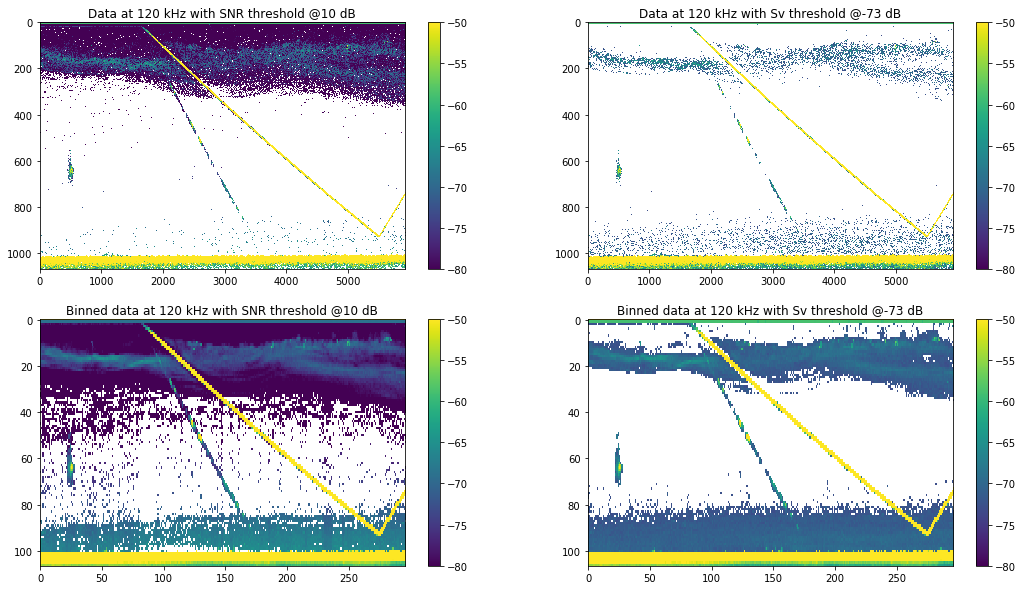

In [29]:
fig,ax = plt.subplots(2,2,figsize=(18,10))
im0 = ax[0,0].imshow(Sv_corr_120_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im1 = ax[0,1].imshow(Sv_corr_120_th,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Data at 120 kHz with Sv threshold @%d dB' % Sv_th)
im2 = ax[1,0].imshow(Sv_corr_120_SNR_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Binned data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im3 = ax[1,1].imshow(Sv_corr_120_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Binned data at 120 kHz with Sv threshold @%d dB' % Sv_th)

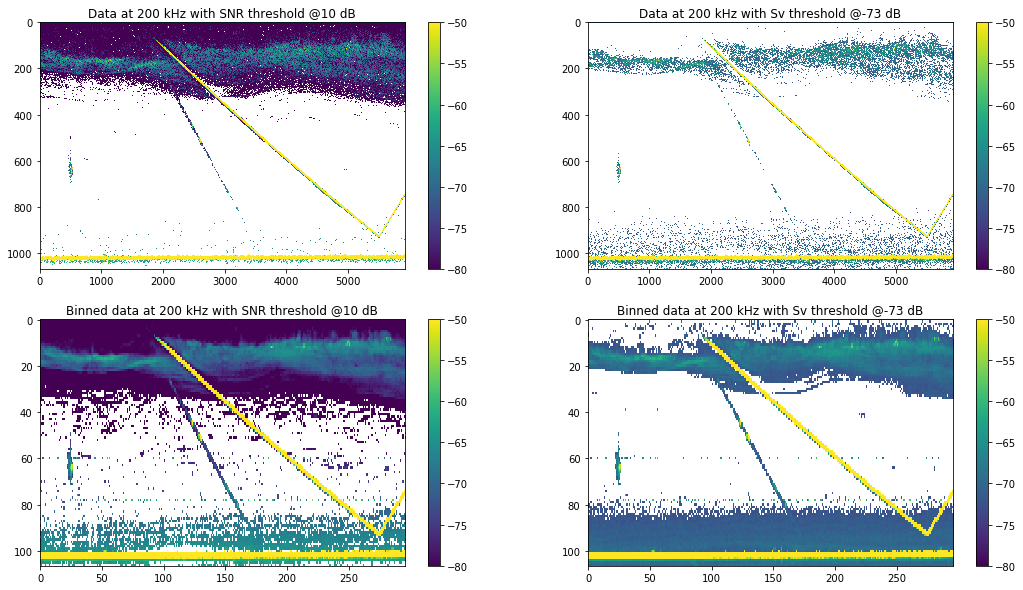

In [184]:
fig,ax = plt.subplots(2,2,figsize=(18,10))
im0 = ax[0,0].imshow(Sv_corr_200_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Data at 200 kHz with SNR threshold @%d dB' % SNR_th)
im1 = ax[0,1].imshow(Sv_corr_200_th,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Data at 200 kHz with Sv threshold @%d dB' % Sv_th)
im2 = ax[1,0].imshow(Sv_corr_200_SNR_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Binned data at 200 kHz with SNR threshold @%d dB' % SNR_th)
im3 = ax[1,1].imshow(Sv_corr_200_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Binned data at 200 kHz with Sv threshold @%d dB' % Sv_th)

## Frequency-differencing

In [200]:
Sv_1 = Sv_corr_200_SNR_mean
Sv_2 = Sv_corr_38_SNR_mean

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

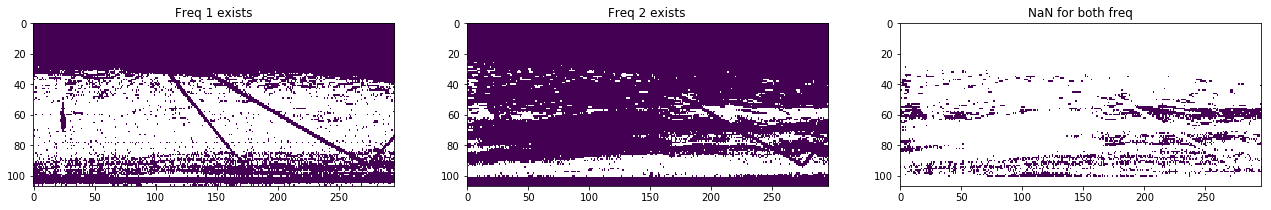

In [204]:
fig,ax = plt.subplots(1,3,figsize=(22,3)) 
ax[0].imshow(np.ma.masked_where(~yes_1,np.ones(yes_1.shape)),aspect='auto')
ax[0].set_title('Freq 1 exists')
ax[1].imshow(np.ma.masked_where(~yes_2,np.ones(yes_2.shape)),aspect='auto')
ax[1].set_title('Freq 2 exists')
ax[2].imshow(np.ma.masked_where(~np.isnan(Sv_diff_12),np.ones(yes_2.shape)),aspect='auto')
ax[2].set_title('NaN for both freq')

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


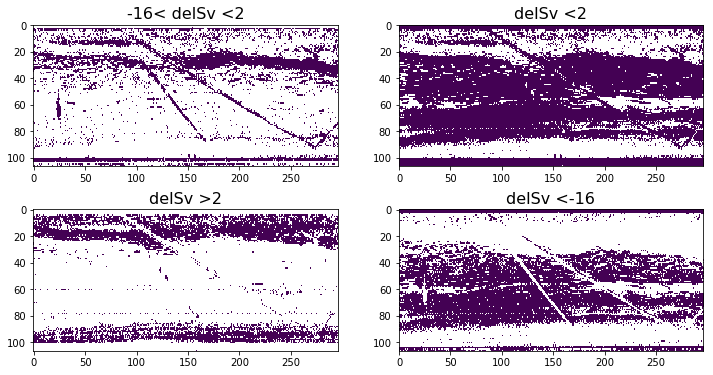

In [225]:
idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16
fig,ax = plt.subplots(2,2,figsize=(12,6))
plt.subplots_adjust(hspace = 0.3)
ax[0,0].imshow(np.ma.masked_where(~idx_fish,np.ones(idx_fish.shape)),aspect='auto')
ax[0,0].set_title('-16< delSv <2',fontsize=16)
ax[0,1].imshow(np.ma.masked_where(~idx_fish_2,np.ones(idx_fish.shape)),aspect='auto')
ax[0,1].set_title('delSv <2',fontsize=16)
ax[1,0].imshow(np.ma.masked_where(~idx_zoop,np.ones(idx_fish.shape)),aspect='auto')
ax[1,0].set_title('delSv >2',fontsize=16)
ax[1,1].imshow(np.ma.masked_where(~idx_other,np.ones(idx_fish.shape)),aspect='auto')
ax[1,1].set_title('delSv <-16',fontsize=16)

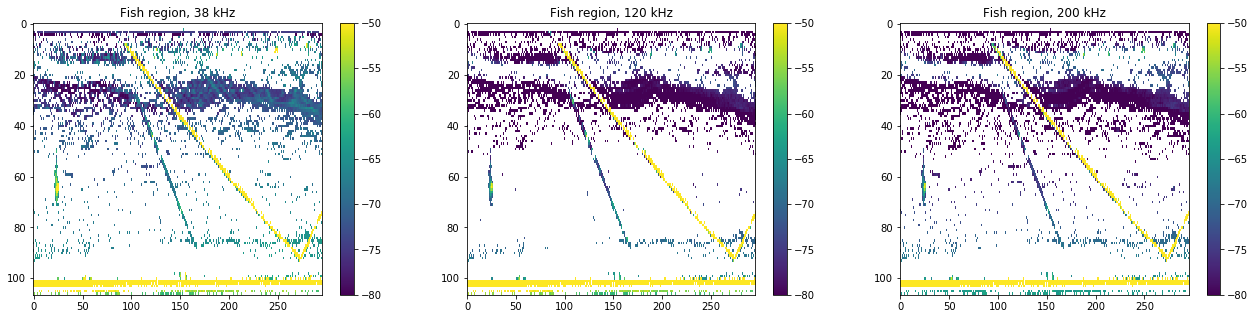

In [226]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish,Sv_corr_38_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish,Sv_corr_120_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish,Sv_corr_200_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

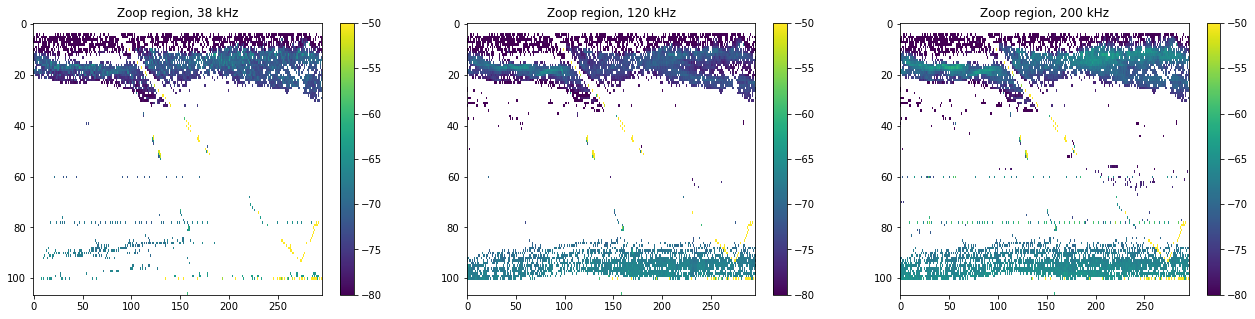

In [227]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_38_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_120_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_200_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')

## Using simple Sv thresholded data

In [228]:
Sv_1 = Sv_corr_200_th_mean
Sv_2 = Sv_corr_38_th_mean

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

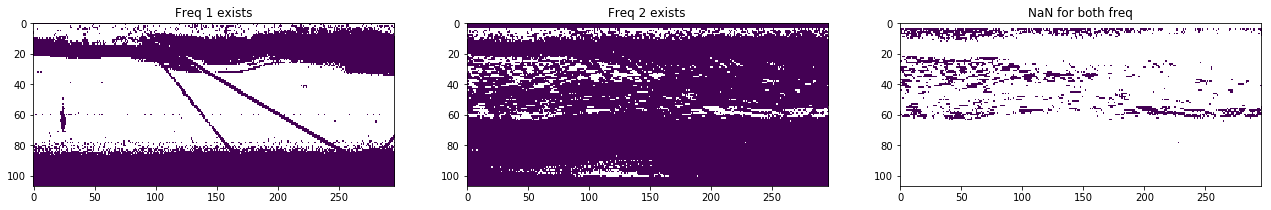

In [229]:
fig,ax = plt.subplots(1,3,figsize=(22,3)) 
ax[0].imshow(np.ma.masked_where(~yes_1,np.ones(yes_1.shape)),aspect='auto')
ax[0].set_title('Freq 1 exists')
ax[1].imshow(np.ma.masked_where(~yes_2,np.ones(yes_2.shape)),aspect='auto')
ax[1].set_title('Freq 2 exists')
ax[2].imshow(np.ma.masked_where(~np.isnan(Sv_diff_12),np.ones(yes_2.shape)),aspect='auto')
ax[2].set_title('NaN for both freq')

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


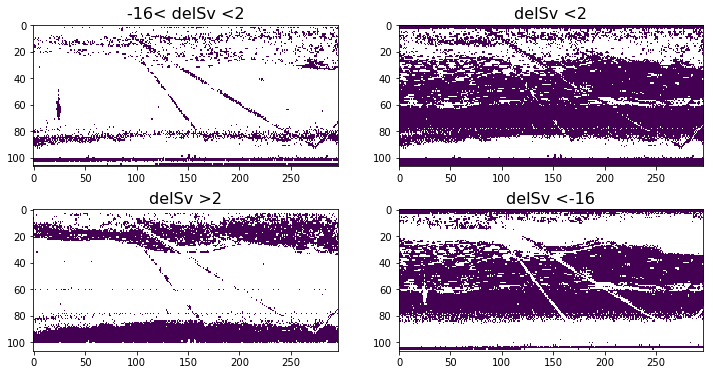

In [230]:
idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16
fig,ax = plt.subplots(2,2,figsize=(12,6))
plt.subplots_adjust(hspace = 0.3)
ax[0,0].imshow(np.ma.masked_where(~idx_fish,np.ones(idx_fish.shape)),aspect='auto')
ax[0,0].set_title('-16< delSv <2',fontsize=16)
ax[0,1].imshow(np.ma.masked_where(~idx_fish_2,np.ones(idx_fish.shape)),aspect='auto')
ax[0,1].set_title('delSv <2',fontsize=16)
ax[1,0].imshow(np.ma.masked_where(~idx_zoop,np.ones(idx_fish.shape)),aspect='auto')
ax[1,0].set_title('delSv >2',fontsize=16)
ax[1,1].imshow(np.ma.masked_where(~idx_other,np.ones(idx_fish.shape)),aspect='auto')
ax[1,1].set_title('delSv <-16',fontsize=16)

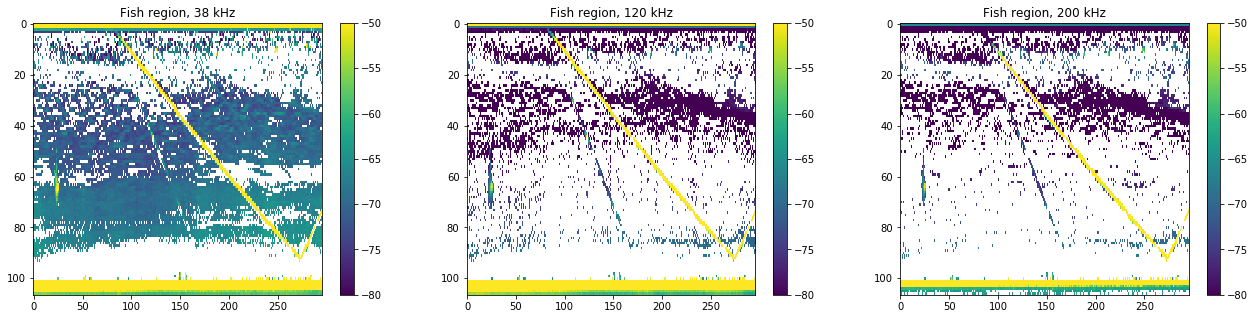

In [233]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_38_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_120_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_200_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

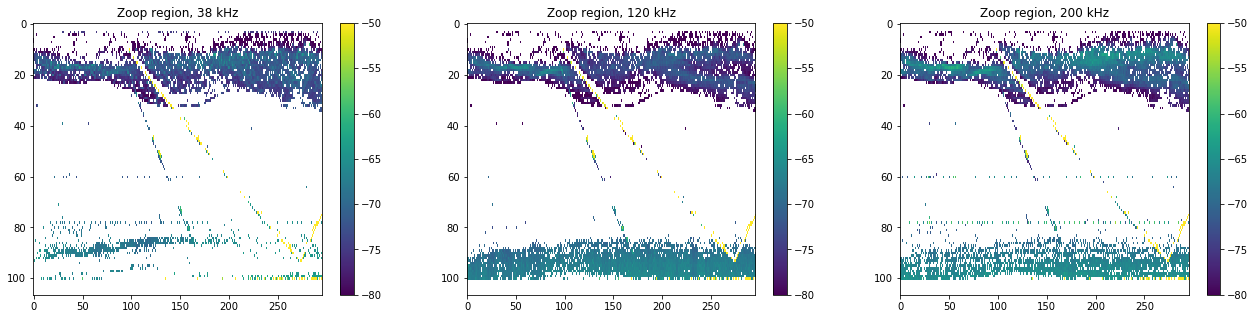

In [234]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_38_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_120_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_200_SNR_mean),aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')

## Multi-frequency color-coding regime from Jech & Michaels 2006

In [1]:
import colors

ImportError: No module named colors

In [411]:
Sv_1 = Sv_corr_38_th_mean
Sv_2 = Sv_corr_120_th_mean
Sv_3 = Sv_corr_200_th_mean
#Sv_1 = Sv_corr_38_SNR_mean
#Sv_2 = Sv_corr_120_SNR_mean
#Sv_3 = Sv_corr_200_SNR_mean

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
yes_3 = ~np.isnan(Sv_3)

Sv_mf = np.copy(Sv_corr_120_SNR_mean)
Sv_mf[~yes_1 & ~yes_2 & ~yes_3] = 0
Sv_mf[ yes_1 & ~yes_2 & ~yes_3] = 1
Sv_mf[ yes_1 &  yes_2 & ~yes_3] = 2
Sv_mf[ yes_1 &  yes_2 &  yes_3] = 3
Sv_mf[ yes_1 & ~yes_2 &  yes_3] = 4
Sv_mf[~yes_1 &  yes_2 & ~yes_3] = 5
Sv_mf[~yes_1 &  yes_2 &  yes_3] = 6
Sv_mf[~yes_1 & ~yes_2 &  yes_3] = 7

In [412]:
mf_color_test = np.array([[0,0,0],\
                          [86,25,148],\
                          [28,33,179],\
                          [0,207,239],\
                          [41,171,71],\
                          [51,204,51],\
                          [255,239,0],\
                          [255,51,0]])/255.

In [413]:
cmap = colors.ListedColormap(mf_color_test)
bounds = range(9)
norm = colors.BoundaryNorm(bounds, cmap.N)

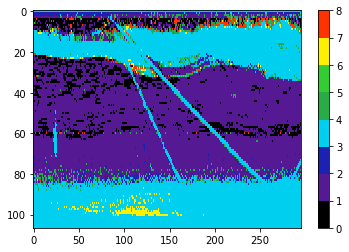

In [414]:
plt.imshow(Sv_mf,aspect='auto',cmap=cmap,norm=norm)
plt.colorbar()

### Colormap for echogram

In [479]:
echogram_cmap = np.array([[255, 255, 255],\
                          [159, 159, 159],\
                          [ 95,  95,  95],\
                          [  0,   0, 255],\
                          [  0,   0, 127],\
                          [  0, 191,   0],\
                          [  0, 127,   0],\
                          [255, 255,   0],\
                          [255, 127,   0],\
                          [255,   0, 191],\
                          [255,   0,   0],\
                          [166,  83,  60],\
                          [120,  60,  40]])/255.

In [480]:
echogram_cmap

array([[ 1.        ,  1.        ,  1.        ],
       [ 0.62352941,  0.62352941,  0.62352941],
       [ 0.37254902,  0.37254902,  0.37254902],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.49803922],
       [ 0.        ,  0.74901961,  0.        ],
       [ 0.        ,  0.49803922,  0.        ],
       [ 1.        ,  1.        ,  0.        ],
       [ 1.        ,  0.49803922,  0.        ],
       [ 1.        ,  0.        ,  0.74901961],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.65098039,  0.3254902 ,  0.23529412],
       [ 0.47058824,  0.23529412,  0.15686275]])

In [566]:
echogram_cmap_threshold = [-80,-30]

In [567]:
echogram_cmap_threshold[1]-echogram_cmap_threshold[0]

50

In [568]:
e_cmap = colors.ListedColormap(echogram_cmap)
bounds = np.linspace(echogram_cmap_threshold[0],echogram_cmap_threshold[1],e_cmap.N+1)
norm = colors.BoundaryNorm(bounds, e_cmap.N)

In [569]:
e_cmap.N

13

In [570]:
bounds

array([-80.        , -76.15384615, -72.30769231, -68.46153846,
       -64.61538462, -60.76923077, -56.92307692, -53.07692308,
       -49.23076923, -45.38461538, -41.53846154, -37.69230769,
       -33.84615385, -30.        ])

In [571]:
bounds.shape

(14,)

In [572]:
Sv_plot = np.copy(Sv_corr_38_SNR_mean)
Sv_plot[Sv_plot>=echogram_cmap_threshold[1]] = echogram_cmap_threshold[1]
Sv_plot[Sv_plot<echogram_cmap_threshold[0]] = np.nan

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


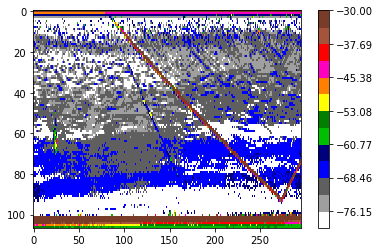

In [573]:
plt.imshow(Sv_corr_38_SNR_mean,aspect='auto',cmap=e_cmap,norm=norm)
plt.colorbar()

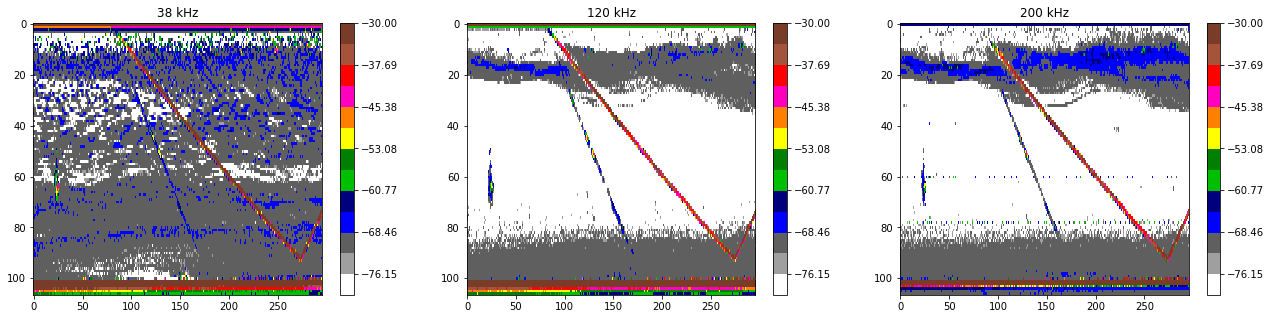

In [577]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_38_th_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_corr_120_th_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_corr_200_th_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

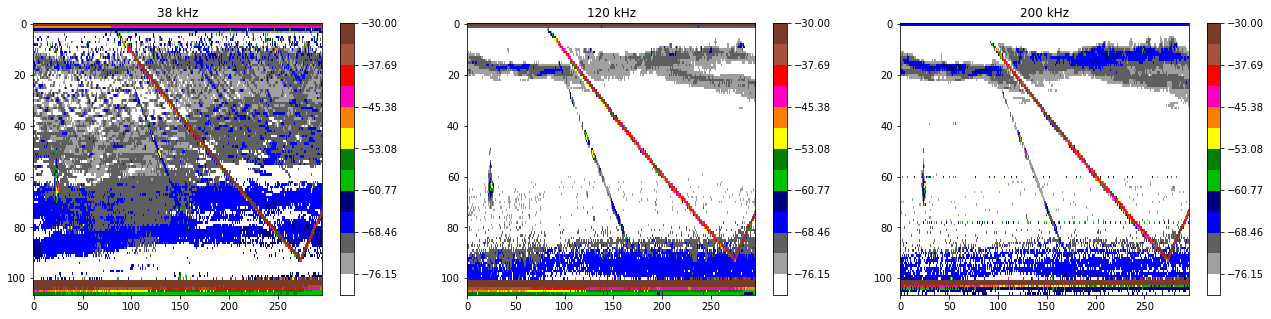

In [578]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_38_SNR_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_corr_120_SNR_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_corr_200_SNR_mean,aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

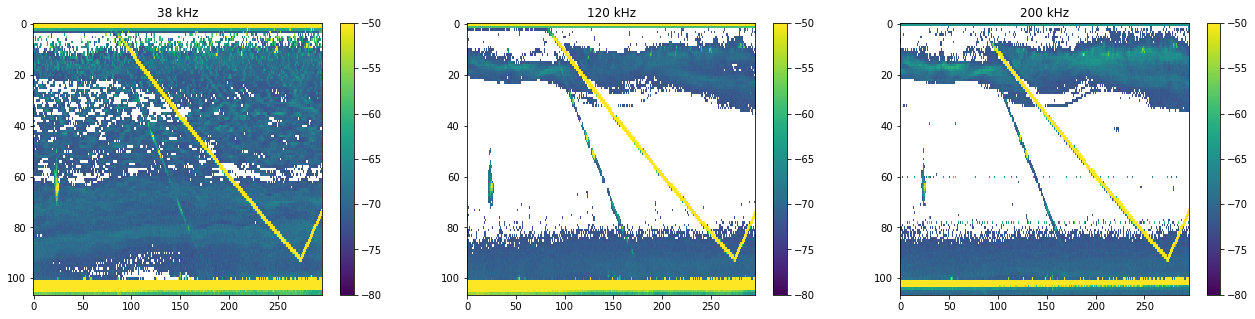

In [575]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_38_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_corr_120_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_corr_200_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

## Plot dB-diff results again using echogram colormap

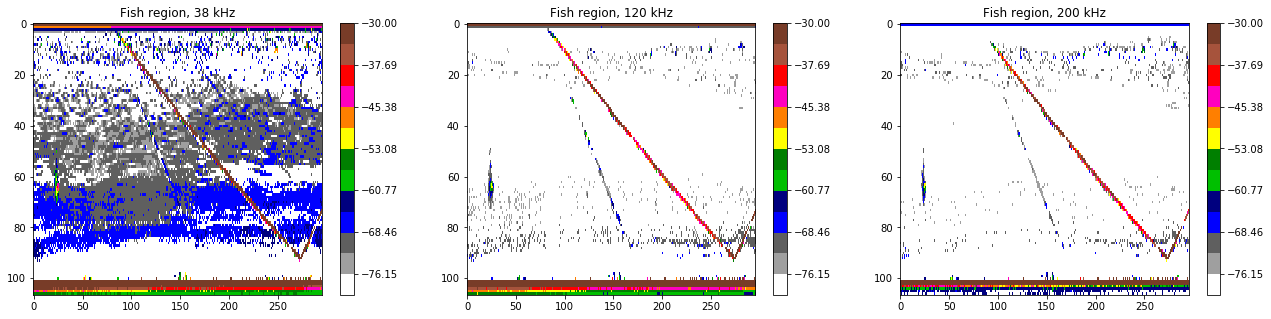

In [579]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_38_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_120_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish_2,Sv_corr_200_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

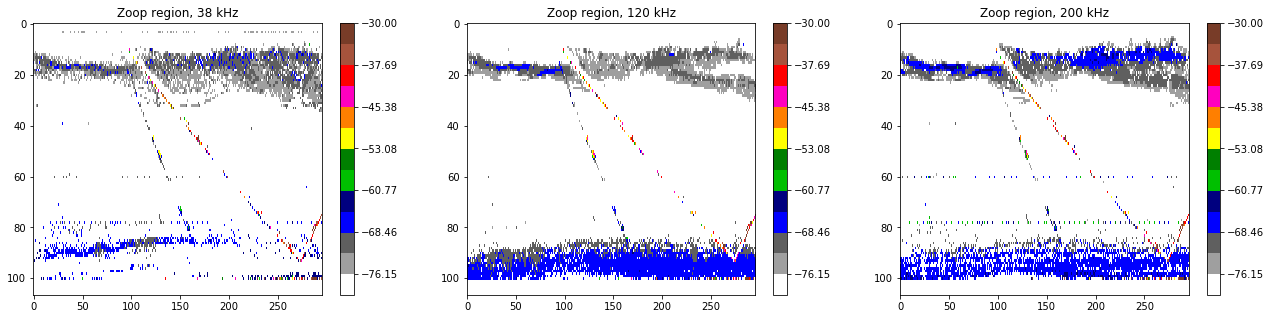

In [580]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_38_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_120_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,Sv_corr_200_SNR_mean),aspect='auto',cmap=e_cmap,norm=norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')